In [1]:
import numpy as np
import matplotlib.pyplot as plt
from src import GaussianMixtureVolume, LinearRegressionVolume

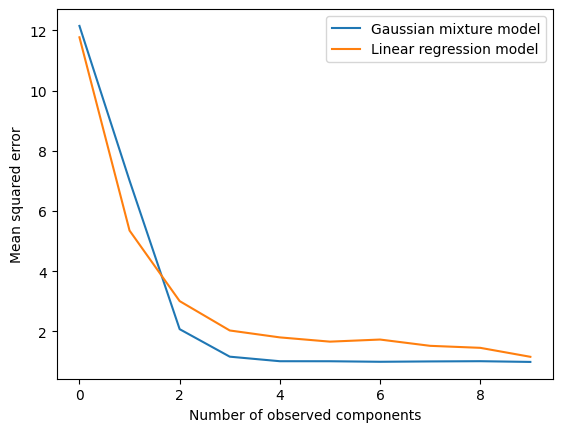

In [74]:
def randcov(m, rank=None):
    A = np.random.randn(m, m if rank is None else rank)
    cov = np.dot(A, A.T) / np.sqrt(m) + np.eye(m)
    return cov

N = 500
num_components = 3
dim = 10
rank = 2

weights = np.random.rand(num_components)
weights /= weights.sum()

mus = [5 * np.random.randn(dim) for i in range(len(weights))]
# sigmas = [randcov(dim, rank=rank) for _ in range(len(weights))]
sigmas = [np.eye(dim) for _ in range(len(weights))]


def sample(n):
    out = np.zeros((n, dim))
    for i in range(n):
        k = np.random.choice(len(weights), p=weights)
        out[i] = np.random.multivariate_normal(mus[k], sigmas[k])
    return out

# test data
fit_data = sample(N)
val_data = sample(N)

# fit gmv
gmv = GaussianMixtureVolume(n_components=num_components, rank=None)
gmv.fit(fit_data)

if rank is not None:
    gmv_factor = GaussianMixtureVolume(n_components=num_components, rank=rank + 2)
    gmv_factor.fit(fit_data)

# fit linear regression
lrv = LinearRegressionVolume(dim)
lrv.fit(fit_data)

# test
calc_mse = lambda pred, true: np.mean(np.square(true - pred))

gmv_mse = [calc_mse(gmv.predict(), val_data)]
lrv_mse = [calc_mse(lrv.predict(), val_data)]
for i in range(dim - 1):
    gmv_mse.append(calc_mse(gmv.predict(val_data[:, : i + 1]), val_data[:, i + 1 :]))
    lrv_mse.append(calc_mse(lrv.predict(val_data[:, : i + 1]), val_data[:, i + 1 :]))

if rank is not None:
    gmv_factor_mse = [calc_mse(gmv_factor.predict(), val_data)]
    for i in range(dim - 1):
        gmv_factor_mse.append(calc_mse(gmv_factor.predict(val_data[:, : i + 1]), val_data[:, i + 1 :]))
    plt.plot(gmv_factor_mse, label="Gaussian factor mixture model")

plt.plot(gmv_mse, label="Gaussian mixture model")
plt.plot(lrv_mse, label="Linear regression model")
plt.xlabel("Number of observed components")
plt.ylabel("Mean squared error")
plt.legend()
plt.show()